In [1]:
# start with the libraries
# get environment information

import sys
print(sys.version)
print(sys.executable)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
//anaconda3/envs/timeseries36/bin/python


In [2]:
# import the base libraries
# standard libraries
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import os
import math
from itertools import cycle
import datetime
from datetime import datetime as dt
from datetime import timedelta

# plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# to visualize all of the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import re
import csv
import json
import ast
from pandas.io.json import json_normalize

pd.options.display.max_colwidth = 2000
pd.set_option('display.max_rows', 100)


# for database connectivity
import psycopg2
import getpass

print(os.getcwd())

/Users/bryanbutler/Documents/Python/Forecasting/EWS


In [3]:
# user
# stream=sys.stderr
uid = getpass.getpass()

········


In [4]:
# pwd

pwd = getpass.getpass()

········


In [6]:
# set the cutoff date

cutoff_date = '2020-02-01'

In [7]:
# query
# this is for all key EWS data
# check the end date

sql_query = """
SELECT
       CAST(lcad.date_ride AS date) AS date_ride,
       CASE WHEN dt.holiday_flag LIKE 'Y' THEN 1 ELSE 0 END AS holiday,
       lcad.call_center_state,
       COUNT(DISTINCT lcad.ride_key) AS gross_rides,
       COUNT(distinct CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.ride_key ELSE NULL END) AS verified_paid_rides,
       SUM(CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.cost_usd ELSE 0 END ) AS verified_paid_costs,
       SUM(CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.miles ELSE 0 END ) AS verified_paid_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.ride_key ELSE NULL END) AS verified_paid_ambulatory_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_ambulatory_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.miles ELSE NULL END) AS verified_paid_ambulatory_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.ride_key ELSE NULL END) AS verified_paid_stretcher_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_stretcher_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.miles ELSE NULL END) AS verified_paid_stretcher_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.ride_key ELSE NULL END) AS verified_paid_wheelchair_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_wheelchair_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.miles ELSE NULL END) AS verified_paid_wheelchair_miles,
       
       count(distinct lcad.rider_code) AS Riders

FROM dw.fact_lcad_ride lcad

LEFT JOIN dw.dim_date dt
    ON lcad.date_dim_id = dt.date_dim_id
WHERE
      provider_type_name NOT IN ('Public Transit', 'Gas Reimbursement', 'Unassigned')
  AND provider_type_name IS NOT NULL
  AND date(date_ride) < %s 
  AND lcad.provider_is_lcad = 'LCAD'
  AND lcad.broker_client_contract_type != 'FFS'
  AND lcad.los_group_desc in ('Ambulatory' , 'Wheelchair', 'Stretcher')
GROUP BY date_ride, holiday, call_center_state
ORDER BY date_ride

""" 

In [8]:
data = pd.read_sql_query(sql = sql_query, con = con, params = [cutoff_date])
data.head()

,date_ride,holiday,call_center_state,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
0,2014-01-01,1,HI,765,8,480.65,162,463,365.25,"4,154.00",2,0.00,4.00,300,115.40,"2,162.00",387
1,2014-01-01,1,MO,881,451,"14,106.09",6738,587,"7,411.61","8,524.00",5,829.20,49.00,289,"5,865.28","3,693.00",439
2,2014-01-01,1,AZ,303,64,"1,778.93",814,98,390.07,819.00,10,0.00,51.00,195,"1,388.86","1,400.00",153
3,2014-01-01,1,AR,2,2,366.60,92,2,366.60,92.00,0,nan,nan,0,nan,nan,1
4,2014-01-01,1,CA,242,30,"1,040.62",331,153,999.58,"1,139.00",27,0.00,165.00,62,41.04,290.00,128


In [9]:
data.tail()

,date_ride,holiday,call_center_state,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
77167,2020-01-31,0,MA,510,386,"14,787.78",3088,467,"10,172.83","3,728.00",13,"3,949.00",119.00,30,665.95,141.00,255
77168,2020-01-31,0,TN,36,13,412.97,138,36,412.97,313.00,0,nan,nan,0,nan,nan,16
77169,2020-01-31,0,NJ,20756,13945,"499,110.06",128476,16919,"302,080.83","162,674.00",555,"70,196.50","3,654.00",3282,"126,832.73","22,353.00",9910
77170,2020-01-31,0,MO,5420,3866,"122,773.35",65289,3980,"78,505.07","65,801.00",91,"5,612.70","1,486.00",1349,"38,655.58","17,699.00",2703
77171,2020-01-31,0,IL,2997,1900,"65,242.34",23059,2594,"48,072.76","31,547.00",88,"7,744.51",915.00,315,"9,425.07","2,369.00",1481


In [10]:
# replace all NaN with 0
df = data.copy()

df = df.fillna(0)
df.head()

,date_ride,holiday,call_center_state,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
0,2014-01-01,1,HI,765,8,480.65,162,463,365.25,"4,154.00",2,0.00,4.00,300,115.40,"2,162.00",387
1,2014-01-01,1,MO,881,451,"14,106.09",6738,587,"7,411.61","8,524.00",5,829.20,49.00,289,"5,865.28","3,693.00",439
2,2014-01-01,1,AZ,303,64,"1,778.93",814,98,390.07,819.00,10,0.00,51.00,195,"1,388.86","1,400.00",153
3,2014-01-01,1,AR,2,2,366.60,92,2,366.60,92.00,0,0.00,0.00,0,0.00,0.00,1
4,2014-01-01,1,CA,242,30,"1,040.62",331,153,999.58,"1,139.00",27,0.00,165.00,62,41.04,290.00,128


In [11]:
# convert date_ride to date and set as index
# only do this for direct SQL pull

# make a date
df['date_ride'] = pd.to_datetime(df['date_ride'], format='%Y-%m-%d')

# set the index
df = df.set_index(df['date_ride'])

df.head()

,date_ride,holiday,call_center_state,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
date_ride,,,,,,,,,,,,,,,,,
2014-01-01,2014-01-01,1,HI,765,8,480.65,162,463,365.25,"4,154.00",2,0.00,4.00,300,115.40,"2,162.00",387
2014-01-01,2014-01-01,1,MO,881,451,"14,106.09",6738,587,"7,411.61","8,524.00",5,829.20,49.00,289,"5,865.28","3,693.00",439
2014-01-01,2014-01-01,1,AZ,303,64,"1,778.93",814,98,390.07,819.00,10,0.00,51.00,195,"1,388.86","1,400.00",153
2014-01-01,2014-01-01,1,AR,2,2,366.60,92,2,366.60,92.00,0,0.00,0.00,0,0.00,0.00,1
2014-01-01,2014-01-01,1,CA,242,30,"1,040.62",331,153,999.58,"1,139.00",27,0.00,165.00,62,41.04,290.00,128


In [12]:
# convert data to weekly format

# weekly sample drops call center state
wdf = df.resample('W').aggregate({'holiday': np.max,
                                  'gross_rides': np.sum,
                                  'verified_paid_rides': np.sum,
                                  'verified_paid_costs': np.sum,
                                  'verified_paid_miles': np.sum,
                                  'verified_paid_ambulatory_rides': np.sum,
                                  'verified_paid_ambulatory_costs': np.sum,
                                  'verified_paid_ambulatory_miles': np.sum,
                                  'verified_paid_stretcher_rides': np.sum,
                                  'verified_paid_stretcher_costs': np.sum,
                                  'verified_paid_stretcher_miles': np.sum,
                                  'verified_paid_wheelchair_rides': np.sum,
                                  'verified_paid_wheelchair_costs': np.sum,
                                  'verified_paid_wheelchair_miles': np.sum,
                                  'riders': np.sum})
wdf.head()

,holiday,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
date_ride,,,,,,,,,,,,,,,
2014-01-05,1,339193,151170,"3,657,245.83",1858376,276999,"2,521,979.56","2,887,658.00",7172,"267,237.82","62,639.00",55022,"868,028.45","463,980.00",167247
2014-01-12,0,716978,417251,"10,218,253.61",5160147,594478,"7,425,178.64","6,588,932.00",13331,"611,998.27","129,201.00",109169,"2,181,076.70","969,953.00",352948
2014-01-19,0,756659,464330,"11,398,957.14",5772414,629920,"8,320,541.03","6,977,972.00",13909,"679,684.35","130,822.00",112830,"2,398,731.76","1,015,678.00",371953
2014-01-26,0,736905,388920,"9,745,250.59",4933421,613533,"7,050,347.37","6,760,934.00",13468,"607,413.60","125,796.00",109904,"2,087,489.62","982,666.00",362595
2014-02-02,0,759988,414369,"10,209,757.24",4948844,633274,"7,460,196.84","6,883,461.00",13810,"604,284.39","134,792.00",112904,"2,145,276.01","1,006,160.00",373441


In [13]:
wdf.tail()

,holiday,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
date_ride,,,,,,,,,,,,,,,
2020-01-05,1,749414,414331,"13,139,131.03",5031317,607940,"8,957,687.50","7,218,810.00",16022,"1,422,640.14","136,670.00",125452,"2,758,803.39","1,054,256.00",365366
2020-01-12,0,908389,621551,"19,336,829.24",7606709,757523,"13,565,078.86","9,351,593.00",16199,"1,842,429.54","151,266.00",134667,"3,929,320.84","1,234,267.00",442034
2020-01-19,0,948823,641045,"19,797,809.68",7826368,793419,"13,961,672.55","9,760,675.00",16706,"1,887,007.46","159,220.00",138698,"3,949,129.67","1,274,463.00",460722
2020-01-26,0,921449,610019,"18,625,936.12",7366855,770156,"13,097,354.85","9,389,897.00",15736,"1,728,299.96","146,914.00",135557,"3,800,281.31","1,231,521.00",447713
2020-02-02,0,887144,604812,"18,344,719.04",7422359,745613,"13,100,382.28","9,167,830.00",14277,"1,585,200.09","139,944.00",127254,"3,659,136.67","1,198,360.00",430322


In [14]:
# import all of the stats functions to be used

import timeseries_module_v1 as ts

In [15]:
# get the oos data in weeks

oos = pd.read_csv('2019_2020_holidays.csv', index_col='date', parse_dates = True)
oos.head()

,holiday
date,
2019-11-03,0
2019-11-10,0
2019-11-17,0
2019-11-24,0
2019-12-01,1


In [16]:
oos.tail()

,holiday
date,
2020-12-06,0
2020-12-13,0
2020-12-20,0
2020-12-27,1
2021-01-03,0


In [17]:
# clean up the verified_paid portion to vp

wdf.columns = wdf.columns.str.replace('verified_paid','vp')
wdf.head()

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders
date_ride,,,,,,,,,,,,,,,
2014-01-05,1,339193,151170,"3,657,245.83",1858376,276999,"2,521,979.56","2,887,658.00",7172,"267,237.82","62,639.00",55022,"868,028.45","463,980.00",167247
2014-01-12,0,716978,417251,"10,218,253.61",5160147,594478,"7,425,178.64","6,588,932.00",13331,"611,998.27","129,201.00",109169,"2,181,076.70","969,953.00",352948
2014-01-19,0,756659,464330,"11,398,957.14",5772414,629920,"8,320,541.03","6,977,972.00",13909,"679,684.35","130,822.00",112830,"2,398,731.76","1,015,678.00",371953
2014-01-26,0,736905,388920,"9,745,250.59",4933421,613533,"7,050,347.37","6,760,934.00",13468,"607,413.60","125,796.00",109904,"2,087,489.62","982,666.00",362595
2014-02-02,0,759988,414369,"10,209,757.24",4948844,633274,"7,460,196.84","6,883,461.00",13810,"604,284.39","134,792.00",112904,"2,145,276.01","1,006,160.00",373441


In [18]:
wdf.tail()

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders
date_ride,,,,,,,,,,,,,,,
2020-01-05,1,749414,414331,"13,139,131.03",5031317,607940,"8,957,687.50","7,218,810.00",16022,"1,422,640.14","136,670.00",125452,"2,758,803.39","1,054,256.00",365366
2020-01-12,0,908389,621551,"19,336,829.24",7606709,757523,"13,565,078.86","9,351,593.00",16199,"1,842,429.54","151,266.00",134667,"3,929,320.84","1,234,267.00",442034
2020-01-19,0,948823,641045,"19,797,809.68",7826368,793419,"13,961,672.55","9,760,675.00",16706,"1,887,007.46","159,220.00",138698,"3,949,129.67","1,274,463.00",460722
2020-01-26,0,921449,610019,"18,625,936.12",7366855,770156,"13,097,354.85","9,389,897.00",15736,"1,728,299.96","146,914.00",135557,"3,800,281.31","1,231,521.00",447713
2020-02-02,0,887144,604812,"18,344,719.04",7422359,745613,"13,100,382.28","9,167,830.00",14277,"1,585,200.09","139,944.00",127254,"3,659,136.67","1,198,360.00",430322


In [19]:
# create cost per mile

wdf['cpm'] = wdf['vp_costs']/wdf['vp_miles']

In [20]:
print(cutoff_date)

2020-02-01


In [21]:
# reset the index for writing

wdf.reset_index(inplace=True)
wdf.head()

,date_ride,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm
0,2014-01-05,1,339193,151170,"3,657,245.83",1858376,276999,"2,521,979.56","2,887,658.00",7172,"267,237.82","62,639.00",55022,"868,028.45","463,980.00",167247,1.97
1,2014-01-12,0,716978,417251,"10,218,253.61",5160147,594478,"7,425,178.64","6,588,932.00",13331,"611,998.27","129,201.00",109169,"2,181,076.70","969,953.00",352948,1.98
2,2014-01-19,0,756659,464330,"11,398,957.14",5772414,629920,"8,320,541.03","6,977,972.00",13909,"679,684.35","130,822.00",112830,"2,398,731.76","1,015,678.00",371953,1.97
3,2014-01-26,0,736905,388920,"9,745,250.59",4933421,613533,"7,050,347.37","6,760,934.00",13468,"607,413.60","125,796.00",109904,"2,087,489.62","982,666.00",362595,1.98
4,2014-02-02,0,759988,414369,"10,209,757.24",4948844,633274,"7,460,196.84","6,883,461.00",13810,"604,284.39","134,792.00",112904,"2,145,276.01","1,006,160.00",373441,2.06


In [22]:
# write wide and long to .csv

# wdf.to_csv('wdf_cutoff_' + cutoff_date + '.csv', index = False)

In [23]:
# if getting from csv

# wdf = pd.read_csv('wdf_cutoff_2020-02-01.csv',index_col='date_ride', parse_dates = True)

In [24]:
# set index for modeling

wdf.set_index('date_ride', inplace=True)

wdf.head()

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm
date_ride,,,,,,,,,,,,,,,,
2014-01-05,1,339193,151170,"3,657,245.83",1858376,276999,"2,521,979.56","2,887,658.00",7172,"267,237.82","62,639.00",55022,"868,028.45","463,980.00",167247,1.97
2014-01-12,0,716978,417251,"10,218,253.61",5160147,594478,"7,425,178.64","6,588,932.00",13331,"611,998.27","129,201.00",109169,"2,181,076.70","969,953.00",352948,1.98
2014-01-19,0,756659,464330,"11,398,957.14",5772414,629920,"8,320,541.03","6,977,972.00",13909,"679,684.35","130,822.00",112830,"2,398,731.76","1,015,678.00",371953,1.97
2014-01-26,0,736905,388920,"9,745,250.59",4933421,613533,"7,050,347.37","6,760,934.00",13468,"607,413.60","125,796.00",109904,"2,087,489.62","982,666.00",362595,1.98
2014-02-02,0,759988,414369,"10,209,757.24",4948844,633274,"7,460,196.84","6,883,461.00",13810,"604,284.39","134,792.00",112904,"2,145,276.01","1,006,160.00",373441,2.06


In [25]:
# drop the frst one
wdf = wdf.iloc[1:]

wdf.tail(10)

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm
date_ride,,,,,,,,,,,,,,,,
2019-12-01,1,806345,454785,"14,126,386.17",5380618,659284,"9,487,599.07","7,751,301.00",15389,"1,582,280.62","138,519.00",131672,"3,056,506.48","1,127,652.00",391218,2.63
2019-12-08,0,891781,605651,"18,764,461.69",7407834,741986,"13,073,776.11","9,166,155.00",15753,"1,798,886.64","146,785.00",134042,"3,891,798.94","1,235,962.00",434127,2.53
2019-12-15,0,938087,643170,"19,818,762.04",7882771,783812,"13,932,774.65","9,693,231.00",16343,"1,894,271.01","157,864.00",137932,"3,991,716.38","1,262,604.00",455890,2.51
2019-12-22,0,977108,663155,"20,477,134.34",8067030,812946,"14,291,808.32","10,002,599.00",17579,"1,975,632.16","162,465.00",146583,"4,209,693.86","1,329,199.00",474410,2.54
2019-12-29,1,755379,392866,"12,260,914.86",4471997,606860,"8,092,738.39","6,864,299.00",16597,"1,435,556.25","128,936.00",131922,"2,732,620.22","1,058,183.00",368871,2.74
2020-01-05,1,749414,414331,"13,139,131.03",5031317,607940,"8,957,687.50","7,218,810.00",16022,"1,422,640.14","136,670.00",125452,"2,758,803.39","1,054,256.00",365366,2.61
2020-01-12,0,908389,621551,"19,336,829.24",7606709,757523,"13,565,078.86","9,351,593.00",16199,"1,842,429.54","151,266.00",134667,"3,929,320.84","1,234,267.00",442034,2.54
2020-01-19,0,948823,641045,"19,797,809.68",7826368,793419,"13,961,672.55","9,760,675.00",16706,"1,887,007.46","159,220.00",138698,"3,949,129.67","1,274,463.00",460722,2.53
2020-01-26,0,921449,610019,"18,625,936.12",7366855,770156,"13,097,354.85","9,389,897.00",15736,"1,728,299.96","146,914.00",135557,"3,800,281.31","1,231,521.00",447713,2.53


In [26]:
# cut the data for verifiedd paid lag of ~ 66 days

vp_lag_days = 66

vp_lag_wks = int(vp_lag_days/7)+ (vp_lag_days % 7 > 0)


vpdf = wdf.iloc[:-vp_lag_wks]
vpdf.tail()

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm
date_ride,,,,,,,,,,,,,,,,
2019-10-27,0,941371,657373,"20,118,255.70",8017779,786814,"14,109,597.75","9,726,111.00",16044,"1,920,477.23","152,672.00",138513,"4,088,180.72","1,277,123.00",457211,2.51
2019-11-03,0,926706,638173,"19,666,278.46",7794858,773826,"13,798,663.33","9,595,675.00",15862,"1,882,400.31","149,504.00",137018,"3,985,214.82","1,244,995.00",450758,2.52
2019-11-10,0,922273,640352,"19,635,741.11",7828762,769600,"13,709,844.05","9,541,897.00",15767,"1,867,875.49","150,517.00",136906,"4,058,021.57","1,257,141.00",448701,2.51
2019-11-17,0,940787,634039,"19,422,834.40",7684447,786022,"13,520,152.51","9,664,314.00",16179,"1,878,357.34","151,859.00",138586,"4,024,324.55","1,266,742.00",457158,2.53
2019-11-24,0,974640,674751,"20,688,348.19",8244084,813372,"14,424,759.69","10,028,365.00",16672,"2,000,397.61","164,196.00",144596,"4,263,190.89","1,329,777.00",473279,2.51


# Get the Data in the Adjudication Gap
## Use as test data for rides and riders

In [27]:
# -10 might overlap

test = wdf.iloc[-10:]
test

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm
date_ride,,,,,,,,,,,,,,,,
2019-12-01,1,806345,454785,"14,126,386.17",5380618,659284,"9,487,599.07","7,751,301.00",15389,"1,582,280.62","138,519.00",131672,"3,056,506.48","1,127,652.00",391218,2.63
2019-12-08,0,891781,605651,"18,764,461.69",7407834,741986,"13,073,776.11","9,166,155.00",15753,"1,798,886.64","146,785.00",134042,"3,891,798.94","1,235,962.00",434127,2.53
2019-12-15,0,938087,643170,"19,818,762.04",7882771,783812,"13,932,774.65","9,693,231.00",16343,"1,894,271.01","157,864.00",137932,"3,991,716.38","1,262,604.00",455890,2.51
2019-12-22,0,977108,663155,"20,477,134.34",8067030,812946,"14,291,808.32","10,002,599.00",17579,"1,975,632.16","162,465.00",146583,"4,209,693.86","1,329,199.00",474410,2.54
2019-12-29,1,755379,392866,"12,260,914.86",4471997,606860,"8,092,738.39","6,864,299.00",16597,"1,435,556.25","128,936.00",131922,"2,732,620.22","1,058,183.00",368871,2.74
2020-01-05,1,749414,414331,"13,139,131.03",5031317,607940,"8,957,687.50","7,218,810.00",16022,"1,422,640.14","136,670.00",125452,"2,758,803.39","1,054,256.00",365366,2.61
2020-01-12,0,908389,621551,"19,336,829.24",7606709,757523,"13,565,078.86","9,351,593.00",16199,"1,842,429.54","151,266.00",134667,"3,929,320.84","1,234,267.00",442034,2.54
2020-01-19,0,948823,641045,"19,797,809.68",7826368,793419,"13,961,672.55","9,760,675.00",16706,"1,887,007.46","159,220.00",138698,"3,949,129.67","1,274,463.00",460722,2.53
2020-01-26,0,921449,610019,"18,625,936.12",7366855,770156,"13,097,354.85","9,389,897.00",15736,"1,728,299.96","146,914.00",135557,"3,800,281.31","1,231,521.00",447713,2.53


# Set the Forecast Horizon
## Full horizon to include verified paid gap

In [28]:
horizon = 18

month_step = 4

oos_exog = oos.iloc[month_step:month_step + horizon]

oos_exog

,holiday
date,
2019-12-01,1
2019-12-08,0
2019-12-15,0
2019-12-22,0
2019-12-29,1
2020-01-05,1
2020-01-12,0
2020-01-19,0
2020-01-26,0


In [29]:
# set up for forecasting and backtesting
# set the ranges
train = vpdf.copy()

end = len(train)


# Gross Rides
## Uses VP Training Data

In [30]:
series = 'gross_rides'

In [31]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)


model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=13,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        gross_rides   No. Observations:                  307
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 13)   Log Likelihood               -3434.573
Date:                            Thu, 19 Mar 2020   AIC                           6883.147
Time:                                    17:06:19   BIC                           6908.908
Sample:                                01-12-2014   HQIC                          6893.465
                                     - 11-24-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.042e+05   2781.802    -37.452      0.000    -1.1e+05   -9.87e+04
ar.L1          0.0387      0.017      2.294      0.022       0.006       0.072
ar.L2         -0.9698      0.017    -56.140      0.000      -1.004      -0.936
ma.L1         -0.1429      0.011    -13.266      0.000      -0.164      -0.122
ma.L2          0.9940      0.034     28.845      0.000       0.926       1.062
ar.S.L13      -0.1238      0.012    -10.198      0.000      -0.148      -0.100
sigma2      8.697e+08      0.008    1.1e+11      0.000     8.7e+08     8.7e+08
===================================================================================
Ljung-Box (Q):                      167.12   Jarque-Bera (JB):               360.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.80
Prob(H) (two-sided):                  0.06   Kurtosis:                         8.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.05e+26. Standard errors may be unstable.
"""

In [32]:
ts.get_dw(model)

1.4049593179134336

In [34]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

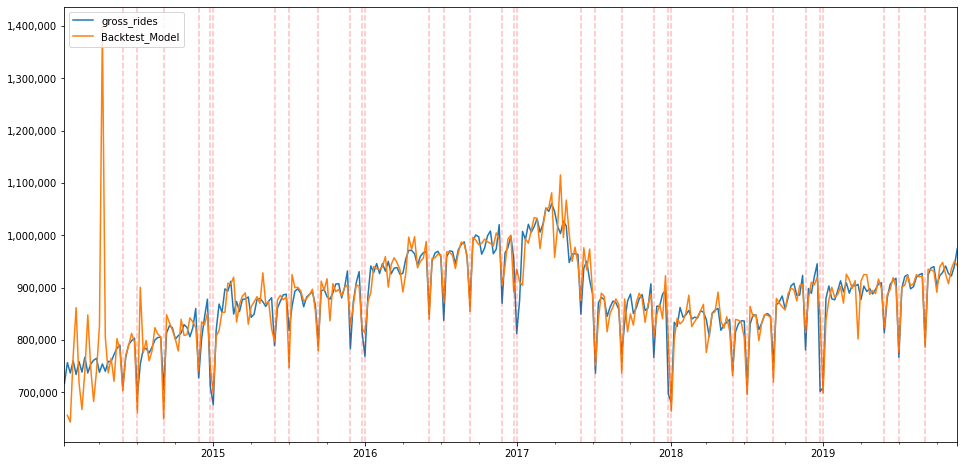

In [35]:
# make the backtest plot

plt.clf()

ts.plot_fit(train[series], backtest, train);

In [36]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

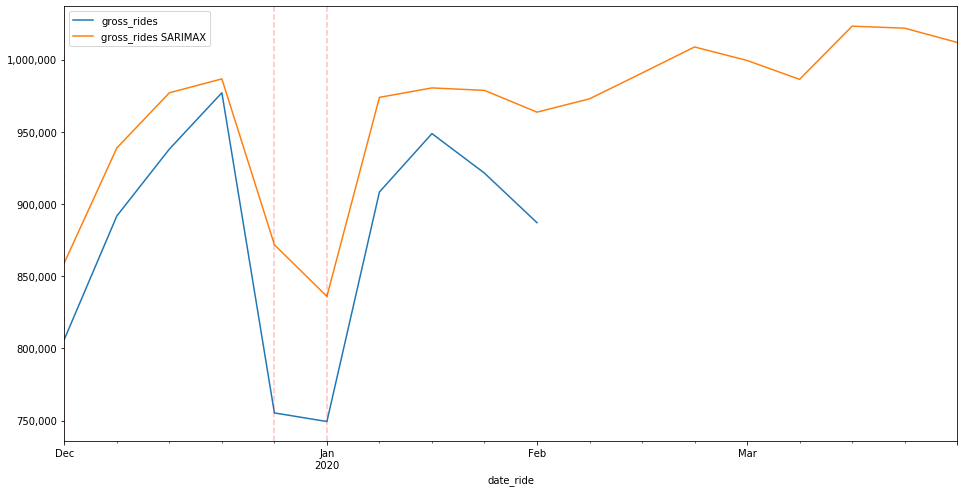

In [37]:
# plot predictions

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=test,
                   vp=False)

In [38]:
# get the comparison of predictions to actual

compare = ts.compare_results(test[series], predictions, test, vp =False)

compare.style.format("{:,.0f}")

,gross_rides,gross_rides SARIMAX
2019-12-01 00:00:00,"806,345","859,358"
2019-12-08 00:00:00,"891,781","938,882"
2019-12-15 00:00:00,"938,087","977,077"
2019-12-22 00:00:00,"977,108","986,730"
2019-12-29 00:00:00,"755,379","871,857"
2020-01-05 00:00:00,"749,414","836,072"
2020-01-12 00:00:00,"908,389","973,921"
2020-01-19 00:00:00,"948,823","980,459"
2020-01-26 00:00:00,"921,449","978,770"
2020-02-02 00:00:00,"887,144","963,689"


In [39]:
# error calculations from predictions and actual

ts.error_calcs(compare, predictions, test[series])

,gross_rides,gross_rides SARIMAX,Error,Percent
2019-12-01 00:00:00,"806,345","859,358","-53,013",-6.57
2019-12-08 00:00:00,"891,781","938,882","-47,101",-5.28
2019-12-15 00:00:00,"938,087","977,077","-38,990",-4.16
2019-12-22 00:00:00,"977,108","986,730","-9,622",-0.98
2019-12-29 00:00:00,"755,379","871,857","-116,478",-15.42
2020-01-05 00:00:00,"749,414","836,072","-86,658",-11.56
2020-01-12 00:00:00,"908,389","973,921","-65,532",-7.21
2020-01-19 00:00:00,"948,823","980,459","-31,636",-3.33
2020-01-26 00:00:00,"921,449","978,770","-57,321",-6.22
2020-02-02 00:00:00,"887,144","963,689","-76,545",-8.63


In [40]:
# make the confidence intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [41]:
intervals

,Predictions,lower gross_rides,upper gross_rides
2019-12-01,"859,357.77","801,494.48","917,221.07"
2019-12-08,"938,882.31","861,193.36","1,016,571.25"
2019-12-15,"977,076.85","883,097.15","1,071,056.55"
2019-12-22,"986,730.12","875,890.59","1,097,569.65"
2019-12-29,"871,856.94","746,768.30","996,945.57"
2020-01-05,"836,071.81","700,510.65","971,632.98"
2020-01-12,"973,921.06","828,445.77","1,119,396.35"
2020-01-19,"980,459.30","823,711.93","1,137,206.66"
2020-01-26,"978,770.22","811,615.29","1,145,925.15"
2020-02-02,"963,688.84","788,442.76","1,138,934.92"


In [42]:
# make the df for plotting OOS

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

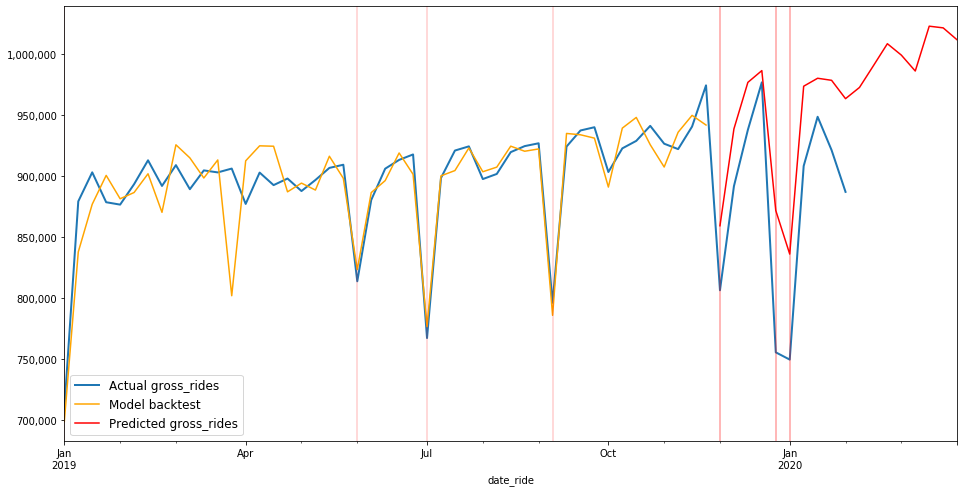

In [43]:
# oos plot

ts.plot_oos(conf_df, wdf, series, backtest, oos_exog, start_date='2019-01-01')

In [44]:
conf_df.reset_index(inplace=True)
conf_df

,index,Predictions,lower gross_rides,upper gross_rides
0,2019-12-01,"859,357.77","801,494.48","917,221.07"
1,2019-12-08,"938,882.31","861,193.36","1,016,571.25"
2,2019-12-15,"977,076.85","883,097.15","1,071,056.55"
3,2019-12-22,"986,730.12","875,890.59","1,097,569.65"
4,2019-12-29,"871,856.94","746,768.30","996,945.57"
5,2020-01-05,"836,071.81","700,510.65","971,632.98"
6,2020-01-12,"973,921.06","828,445.77","1,119,396.35"
7,2020-01-19,"980,459.30","823,711.93","1,137,206.66"
8,2020-01-26,"978,770.22","811,615.29","1,145,925.15"
9,2020-02-02,"963,688.84","788,442.76","1,138,934.92"


# Riders

In [45]:
series = 'riders'

In [46]:
model = ts.build_model(train[series],
                       p=1,
                       d=1,
                       q=1,
                       S=12,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  307
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3240.381
Date:                            Thu, 19 Mar 2020   AIC                           6492.763
Time:                                    17:06:44   BIC                           6514.864
Sample:                                01-12-2014   HQIC                          6501.614
                                     - 11-24-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -5.396e+04   1767.264    -30.534      0.000   -5.74e+04   -5.05e+04
ar.L1          0.3899      0.303      1.287      0.198      -0.204       0.984
ma.L1         -0.5160      0.296     -1.743      0.081      -1.096       0.064
ar.S.L12       0.3738      0.034     10.997      0.000       0.307       0.440
ma.S.L12      -0.8857      0.044    -20.007      0.000      -0.972      -0.799
sigma2      2.346e+08      0.019   1.21e+10      0.000    2.35e+08    2.35e+08
===================================================================================
Ljung-Box (Q):                      255.23   Jarque-Bera (JB):                39.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.56
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.98e+25. Standard errors may be unstable.
"""

In [47]:
ts.get_dw(model)

1.323221512290261

In [48]:
# make backtest

backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

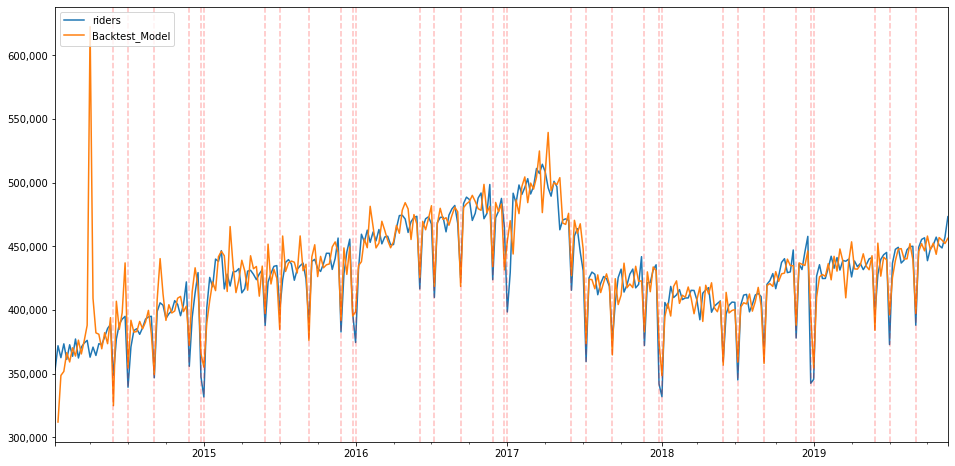

In [49]:
ts.plot_fit(train[series], backtest, train)

In [50]:
predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

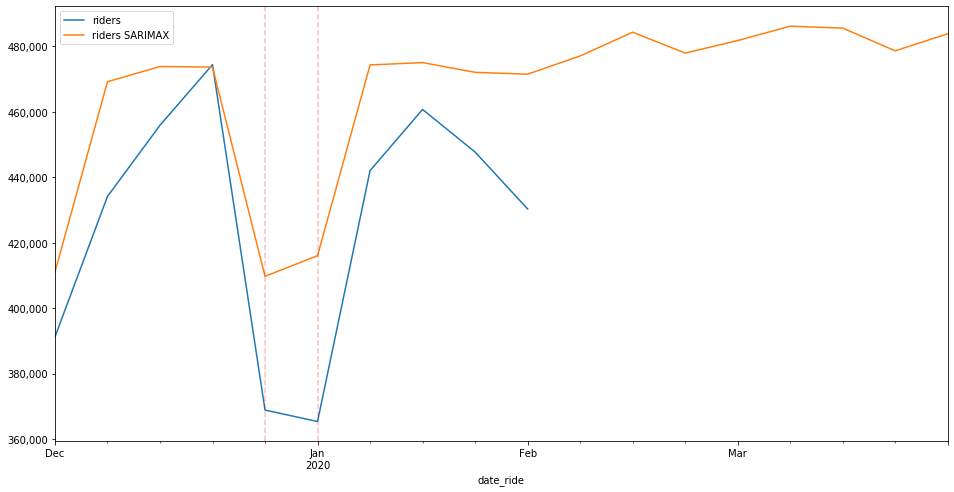

In [51]:
ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=test,
                   vp=False)

In [52]:
compare = ts.compare_results(test[series], predictions, test, vp =False)

compare.style.format("{:,.0f}")

,riders,riders SARIMAX
2019-12-01 00:00:00,"391,218","411,042"
2019-12-08 00:00:00,"434,127","469,188"
2019-12-15 00:00:00,"455,890","473,840"
2019-12-22 00:00:00,"474,410","473,663"
2019-12-29 00:00:00,"368,871","409,737"
2020-01-05 00:00:00,"365,366","416,033"
2020-01-12 00:00:00,"442,034","474,324"
2020-01-19 00:00:00,"460,722","475,040"
2020-01-26 00:00:00,"447,713","472,061"
2020-02-02 00:00:00,"430,322","471,492"


In [53]:
ts.error_calcs(compare, predictions, test[series])

,riders,riders SARIMAX,Error,Percent
2019-12-01 00:00:00,"391,218","411,042","-19,824",-5.07
2019-12-08 00:00:00,"434,127","469,188","-35,061",-8.08
2019-12-15 00:00:00,"455,890","473,840","-17,950",-3.94
2019-12-22 00:00:00,"474,410","473,663",747,0.16
2019-12-29 00:00:00,"368,871","409,737","-40,866",-11.08
2020-01-05 00:00:00,"365,366","416,033","-50,667",-13.87
2020-01-12 00:00:00,"442,034","474,324","-32,290",-7.30
2020-01-19 00:00:00,"460,722","475,040","-14,318",-3.11
2020-01-26 00:00:00,"447,713","472,061","-24,348",-5.44
2020-02-02 00:00:00,"430,322","471,492","-41,170",-9.57


In [54]:
intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [55]:
intervals

,Predictions,lower riders,upper riders
2019-12-01,"411,042.28","381,017.11","441,067.46"
2019-12-08,"469,188.01","429,312.81","509,063.22"
2019-12-15,"473,840.05","426,900.98","520,779.12"
2019-12-22,"473,663.29","420,858.46","526,468.12"
2019-12-29,"409,736.79","351,748.69","467,724.89"
2020-01-05,"416,033.33","353,322.33","478,744.33"
2020-01-12,"474,323.80","407,233.61","541,413.98"
2020-01-19,"475,039.53","403,843.45","546,235.61"
2020-01-26,"472,061.44","396,985.32","547,137.57"
2020-02-02,"471,492.23","392,727.58","550,256.88"


In [56]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

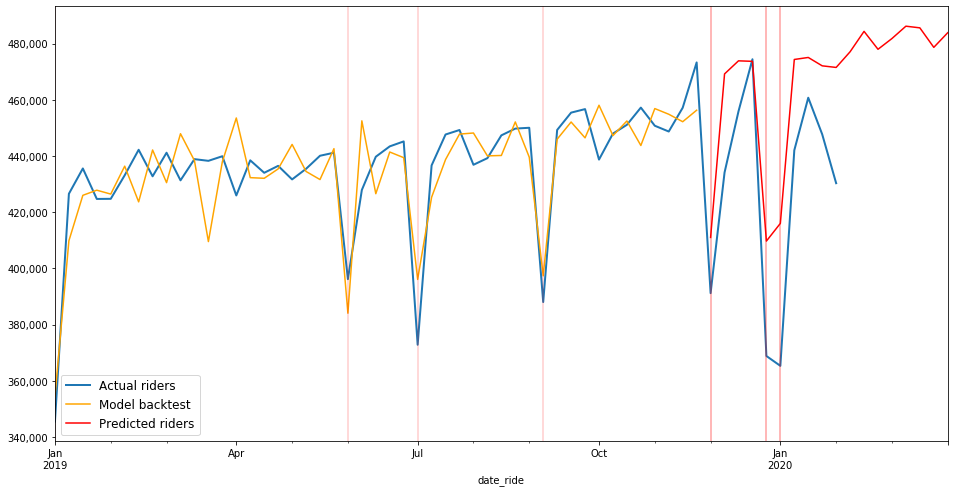

In [57]:
ts.plot_oos(conf_df, wdf, series, backtest, oos_exog, start_date='2019-01-01')

# Reset Training and Exog for OOS Modeling

In [58]:
# set up for forecasting and backtesting
# set the ranges
train = wdf.copy()

end = len(train)

train.tail()

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm
date_ride,,,,,,,,,,,,,,,,
2020-01-05,1,749414,414331,"13,139,131.03",5031317,607940,"8,957,687.50","7,218,810.00",16022,"1,422,640.14","136,670.00",125452,"2,758,803.39","1,054,256.00",365366,2.61
2020-01-12,0,908389,621551,"19,336,829.24",7606709,757523,"13,565,078.86","9,351,593.00",16199,"1,842,429.54","151,266.00",134667,"3,929,320.84","1,234,267.00",442034,2.54
2020-01-19,0,948823,641045,"19,797,809.68",7826368,793419,"13,961,672.55","9,760,675.00",16706,"1,887,007.46","159,220.00",138698,"3,949,129.67","1,274,463.00",460722,2.53
2020-01-26,0,921449,610019,"18,625,936.12",7366855,770156,"13,097,354.85","9,389,897.00",15736,"1,728,299.96","146,914.00",135557,"3,800,281.31","1,231,521.00",447713,2.53
2020-02-02,0,887144,604812,"18,344,719.04",7422359,745613,"13,100,382.28","9,167,830.00",14277,"1,585,200.09","139,944.00",127254,"3,659,136.67","1,198,360.00",430322,2.47


In [59]:
# reset the exogenous series
# roll forward what has occurred

roll_fwd = 14

short_horizon = 12

short_exog = oos.iloc[roll_fwd:roll_fwd + short_horizon]

short_exog

,holiday
date,
2020-02-09,0
2020-02-16,0
2020-02-23,0
2020-03-01,0
2020-03-08,0
2020-03-15,0
2020-03-22,0
2020-03-29,0
2020-04-05,0


# Gross Rides - OOS

In [60]:
series = 'gross_rides'

In [61]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)                              

model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        gross_rides   No. Observations:                  317
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood               -3587.841
Date:                            Thu, 19 Mar 2020   AIC                           7189.682
Time:                                    17:06:58   BIC                           7215.702
Sample:                                01-12-2014   HQIC                          7200.091
                                     - 02-02-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.121e+05   5.32e-08  -2.11e+12      0.000   -1.12e+05   -1.12e+05
ar.L1          0.2553      0.003     73.521      0.000       0.249       0.262
ar.L2         -0.9997      0.002   -500.906      0.000      -1.004      -0.996
ma.L1         -0.2599      0.012    -21.623      0.000      -0.284      -0.236
ma.L2          0.9993      0.058     17.187      0.000       0.885       1.113
ar.S.L12      -0.2291      0.012    -19.224      0.000      -0.252      -0.206
sigma2      9.818e+08   5.66e-11   1.73e+19      0.000    9.82e+08    9.82e+08
===================================================================================
Ljung-Box (Q):                      164.67   Jarque-Bera (JB):                44.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.15
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.26e+33. Standard errors may be unstable.
"""

In [62]:
ts.get_dw(model)

1.6743918197361596

In [63]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

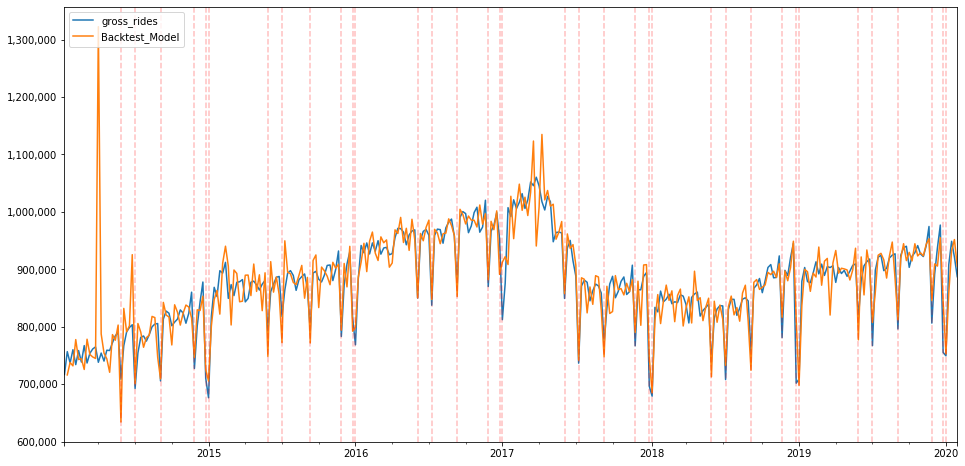

In [64]:
# plot model backtest

plt.clf()

ts.plot_fit(train[series], backtest, train);

In [65]:
predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(short_exog)-1,
                               exog_data=short_exog)

In [66]:
# make the OOS intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=short_horizon,
                                     exog_data = short_exog)

In [67]:
intervals

,Predictions,lower gross_rides,upper gross_rides
2020-02-09,"885,088.40","823,533.19","946,643.61"
2020-02-16,"924,209.49","837,332.59","1,011,086.40"
2020-02-23,"897,242.41","791,124.89","1,003,359.93"
2020-03-01,"873,139.21","750,693.11","995,585.32"
2020-03-08,"889,388.48","752,365.66","1,026,411.29"
2020-03-15,"921,554.89","771,383.48","1,071,726.29"
2020-03-22,"851,492.36","689,393.66","1,013,591.06"
2020-03-29,"855,707.77","682,521.54","1,028,893.99"
2020-04-05,"871,494.59","687,754.01","1,055,235.16"
2020-04-12,"895,585.59","701,813.29","1,089,357.88"


In [68]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=short_horizon,
                           exog_data = short_exog)

In [69]:
# make the final df for merging

gross_rides_fcast = ts.oos_weekly_df(model=model,
                               steps_ahead=short_horizon,
                               exog_data = short_exog,
                               series = series,
                               add_date = True)

gross_rides_fcast

,gross_rides,lower_gross_rides,upper_gross_rides,fcast_date
2020-02-09,"885,088.40","823,533.19","946,643.61",2020-03-19
2020-02-16,"924,209.49","837,332.59","1,011,086.40",2020-03-19
2020-02-23,"897,242.41","791,124.89","1,003,359.93",2020-03-19
2020-03-01,"873,139.21","750,693.11","995,585.32",2020-03-19
2020-03-08,"889,388.48","752,365.66","1,026,411.29",2020-03-19
2020-03-15,"921,554.89","771,383.48","1,071,726.29",2020-03-19
2020-03-22,"851,492.36","689,393.66","1,013,591.06",2020-03-19
2020-03-29,"855,707.77","682,521.54","1,028,893.99",2020-03-19
2020-04-05,"871,494.59","687,754.01","1,055,235.16",2020-03-19
2020-04-12,"895,585.59","701,813.29","1,089,357.88",2020-03-19


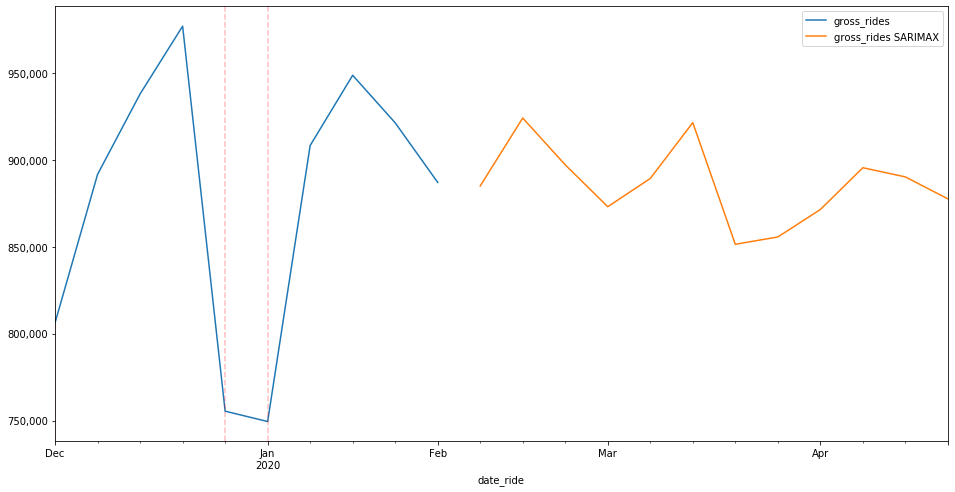

In [70]:
# oos prediction plot

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=oos_exog,
                   vp=False)

# Riders - OOS

In [71]:
series = 'riders'

In [72]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=2)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  317
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -3344.815
Date:                            Thu, 19 Mar 2020   AIC                           6709.630
Time:                                    17:07:14   BIC                           6746.801
Sample:                                01-12-2014   HQIC                          6724.499
                                     - 02-02-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -5.442e+04   1699.930    -32.013      0.000   -5.78e+04   -5.11e+04
ar.L1          0.3399      0.291      1.167      0.243      -0.231       0.911
ar.L2         -0.6107      0.165     -3.702      0.000      -0.934      -0.287
ma.L1         -0.4366      0.300     -1.454      0.146      -1.025       0.152
ma.L2          0.5378      0.192      2.794      0.005       0.161       0.915
ar.S.L12       0.7465      0.185      4.027      0.000       0.383       1.110
ar.S.L24      -0.2870      0.068     -4.210      0.000      -0.421      -0.153
ma.S.L12      -1.2613      0.190     -6.625      0.000      -1.634      -0.888
ma.S.L24       0.4226      0.170      2.487      0.013       0.090       0.756
sigma2      2.212e+08      0.023   9.77e+09      0.000    2.21e+08    2.21e+08
===================================================================================
Ljung-Box (Q):                      161.54   Jarque-Bera (JB):                55.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.61
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.71e+25. Standard errors may be unstable.
"""

In [ ]:
ts.get_dw(model)

In [ ]:
# make backtest

backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(short_exog)-1,
                               exog_data=short_exog)

In [ ]:
# make the OOS intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=short_horizon,
                                     exog_data = short_exog)

In [ ]:
intervals

In [ ]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=short_horizon,
                           exog_data = short_exog)

In [ ]:
# oos prediction plot

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=short_exog,
                   vp=False)

In [ ]:
# make the final df for merging

riders_fcast = ts.oos_weekly_df(model=model,
                               steps_ahead=short_horizon,
                               exog_data = short_exog,
                               series = series,
                               add_date = False)

riders_fcast

# Begin VP Series

## Reset Values for VP Train

In [ ]:
# set the ranges

# make the training set
train = vpdf.copy()

# set the end point
end = len(train)

# set the truncation point to excude vp lag
print(vp_lag_wks)

train.tail()

In [ ]:
# reset exog
# roll forward what has occurred
# roll_fwd = 14

# reset horizon
horizon = horizon + month_step

oos_exog = oos.iloc[month_step:short_horizon + roll_fwd]

oos_exog

# Ver Pd Rides

In [ ]:
series = 'vp_rides'

In [ ]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

model = ts.build_model(train[series],
                       p=1,
                       d=0,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train);

In [ ]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# make prediction intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# oos plot

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01');

In [ ]:
# make final series

vp_rides = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_rides

# Ver Pd Costs

In [ ]:
series = 'vp_costs'

In [ ]:
model = ts.build_model(train[series],
                       p=2,
                       d=0,
                       q=0,
                       S=2,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# make prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [ ]:
# make final series

vp_costs = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_costs

# Ver Pd Miles

In [ ]:
series = 'vp_miles'

In [ ]:
model = ts.build_model(train[series],
                       p=1,
                       d=1,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01');

In [ ]:
# make final series

vp_miles = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_miles

# Ver Pd Amb Rides

In [ ]:
series = 'vp_ambulatory_rides'

In [ ]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=1,
                       S=4,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# oos plot

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [ ]:
# make final series

vp_ambulatory_rides = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_rides

# Ver Pd Amb Costs

In [ ]:
series = 'vp_ambulatory_costs'

In [ ]:
model = ts.build_model(train[series],
                       p=1,
                       d=0,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# oos predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [ ]:
# make final series

vp_ambulatory_costs = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_costs

# Ver Pd Amb Miles

In [ ]:
series = 'vp_ambulatory_miles'

In [ ]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=1,
                       S=4,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# oos predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [ ]:
# make final series

vp_ambulatory_miles = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_miles

# Ver Pd Stretcher Rides

In [ ]:
series = 'vp_stretcher_rides'

In [ ]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=1,
                       S=8,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for oos

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [ ]:
# make final series

vp_stretcher_rides = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_rides

# Ver Pd Stretcher Costs

In [ ]:
series = 'vp_stretcher_costs'

In [ ]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=5,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [ ]:
# make final series

vp_stretcher_costs = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_costs

# Ver Pd Stretcher Miles

In [ ]:
series = 'vp_stretcher_miles'

In [ ]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=5,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [ ]:
# make final series

vp_stretcher_miles = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_miles

# Ver Pd Wheelchair Rides

In [ ]:
series = 'vp_wheelchair_rides'

In [ ]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=12,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# make prediction intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [ ]:
# make final series

vp_wheelchair_rides = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_rides

# Ver Pd Wheelchair Costs

In [ ]:
series = 'vp_wheelchair_costs'

In [ ]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=6,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for oos plt

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [ ]:
# make final series

vp_wheelchair_costs = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_costs

# Ver Pd Wheelchair Miles

In [ ]:
series = 'vp_wheelchair_miles'

In [ ]:
# get the outlier
outlier = train[series].quantile(0.95)

# get the median
median = train[series].quantile(0.50)

# replace the outliers
train[series] = np.where(train[series] > outlier, median,train[series])

In [ ]:
model = ts.build_model(train[series],
                       p=0,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=0,
                       D=1,
                       Q=2)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for oos plt

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [ ]:
# make final series

vp_wheelchair_miles = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_miles

# CPM

In [ ]:
series = 'cpm'

In [ ]:
train[series].describe()

In [ ]:
# get the outlier
outlier = train[series].quantile(.01)

# get the median
median = train[series].quantile(0.50)

# replace the outliers
train[series] = np.where(train[series] < outlier, median,train[series])

print(outlier)
print(median)
train[series].describe()

In [ ]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

model = ts.build_model(train[series],
                       p=3,
                       d=1,
                       q=0,
                       S=6,
                       exog_data = train['holiday'],
                       P=3,
                       D=1,
                       Q=0)

model.summary()

In [ ]:
ts.get_dw(model)

In [ ]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

In [ ]:
# plt the backtest

ts.plot_fit(train[series], backtest, train)

In [ ]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [ ]:
# conf intervals for oos

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [ ]:
intervals

In [ ]:
# make df for plotting

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

In [ ]:
# plot oos 

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01', decimal = True)

In [ ]:
# Make final series

cpm_fcast = ts.oos_weekly_df(model=model,
                       steps_ahead=horizon,
                       exog_data = oos_exog,
                       series = series,
                       add_date = False)

cpm_fcast

# Begin to Combine Data Frames

In [ ]:
list_cols = list(wdf.columns)

# change holiday to holidays

list_cols[1] = 'holidays'


list_cols

In [ ]:
# remove riders and gross rides
exclude = ['date_ride', 'gross_rides', 'riders', 'holiday', 'holidays', 'cpm']
vp_cols = [e for e in list_cols if e not in exclude]

vp_cols


In [ ]:
# make a list of dataframes using the columns
holidays = oos_exog

# create empty list
vp_df = []

for df in vp_cols:
    # use eval to handle the string name as actual df
    df = pd.DataFrame(eval(df))
    vp_df.append(df)
    

vp_df

In [ ]:
# concat them all into a single df
combined_wide = pd.concat(vp_df, axis = 1)
combined_wide

In [ ]:
# SKIP THIS STEP
# truncate the series to remove past

# week_incr = 1

# begin = short_horizon + week_incr

# combined_wide_red = combined_wide.iloc[begin:]
# combined_wide_red.head()

In [ ]:
len(holidays)

In [ ]:
holidays

In [ ]:
gross_rides_fcast

In [ ]:
riders_fcast

In [ ]:
cpm_fcast

In [ ]:
cpm_fcast

In [ ]:
# concatonate them all


all_forecasts = pd.concat([holidays[0:19], gross_rides_fcast, riders_fcast, cpm_fcast, combined_wide], axis = 1)
all_forecasts


In [ ]:
#Sometime skip this step

# all_forecasts = all_forecasts[1:19]
# all_forecasts

In [ ]:
all_forecasts.tail()

In [ ]:
# row['date'] - timedelta(days = 1)

# set the forecast date
now = dt.now().date()
past = 19
forecast_date = now - timedelta(days = past) 
forecast_date

In [ ]:
# set the forecast date for the whole dataset
all_forecasts['fcast_date'] = forecast_date
all_forecasts

In [ ]:
# move the fcast_date for simplicity

fc = all_forecasts['fcast_date']
all_forecasts.drop(labels=['fcast_date'], axis=1,inplace = True)
all_forecasts.insert(0, 'fcast_date', fc)

all_forecasts

In [ ]:
# reset the index
all_forecasts.reset_index(inplace=True)

# rename the column
all_forecasts.rename(columns = {'index':'week_ending'}, inplace = True)

# reassign the index with column name
all_forecasts.set_index('week_ending', inplace = True)

all_forecasts


In [ ]:
all_cols = list(all_forecasts.columns)
all_cols

In [ ]:
# change names of gross_rides, riders and cpm

col_dict = {'gross_rides': 'gross_rides_fcast', 'riders': 'riders_fcast', 'cpm': 'cpm_fcast'} 

all_forecasts.columns = [col_dict.get(x, x) for x in all_forecasts.columns]


all_forecasts


In [ ]:
# make a date string for the file name

dt_str = all_forecasts['fcast_date'][0].strftime("%m%d%Y")
dt_str

In [ ]:
os.getcwd()

In [ ]:
# fill na

all_forecasts = all_forecasts.fillna(0)
all_forecasts

In [ ]:
# reset index before writing

all_forecasts.reset_index(inplace= True)

all_forecasts.to_csv('wide_ews_fcast_' + dt_str + '.csv', index = False)

all_forecasts


In [ ]:
# change holiday column type

all_forecasts['holiday'] = all_forecasts['holiday'].astype(bool)

all_forecasts.holiday.dtype

In [ ]:
# SKIP THIS STEP
# trim off long horizon

# all_forecasts = all_forecasts.iloc[0:8]
# all_forecasts

# Upload the Forecasts

In [ ]:
from sqlalchemy import create_engine

In [ ]:
# enter user for dw_datascience

uid = getpass.getpass(stream=sys.stderr)

In [ ]:
pwd = getpass.getpass()

In [ ]:
# make the connection and upload the dataframe
conn_string = 'postgresql+psycopg2://' + uid + ':' + pwd + '@rs-prd-bi-cluster.cdw0722fdg2r.us-east-1.redshift.amazonaws.com:5439/dw_main'

In [ ]:
conn = create_engine(conn_string)

In [ ]:
# all_forecasts

all_forecasts.to_sql(name = 'ews_forecasts',
          con = conn,
          schema='dw_datascience',
          index=False,
          if_exists='append')

In [ ]:
del uid, pwd, conn_string

In [ ]:
agg_cols = all_forecasts.columns
agg_cols

In [ ]:
all_forecasts.head(10)

In [ ]:
# convert holiday to 1, 0
all_forecasts['holiday'] =  all_forecasts['holiday'].astype(int)

all_forecasts.head()

In [ ]:
# drop the confidence limits
import re

regex = r"(upper_[a-z]*)|(lower_[a-z]*)"

weekly_red = all_forecasts[all_forecasts.columns.drop(list(all_forecasts.filter(regex=regex)))]
weekly_red.head()

In [ ]:
month_roll = all_forecasts.copy()
month_roll.head()

In [ ]:
list_cols =list(month_roll.columns)
list_cols

In [ ]:
list_cols[46]

In [ ]:
month_df = month_roll.resample('M').agg({list_cols[1]: np.sum, list_cols[2]: np.sum, list_cols[3]: np.sum,
                                         list_cols[4]: np.sum, list_cols[5]: np.sum, list_cols[6]: np.sum,
                                         list_cols[7]: np.sum,
                                         list_cols[8]: np.mean, list_cols[9]: np.mean, list_cols[10]: np.mean,
                                         list_cols[11]: np.sum, list_cols[12]: np.sum, list_cols[13]: np.sum,
                                         list_cols[14]: np.sum, list_cols[15]: np.sum, list_cols[16]: np.sum,
                                         list_cols[17]: np.sum, list_cols[18]: np.sum, list_cols[19]: np.sum,
                                         list_cols[20]: np.sum, list_cols[21]: np.sum, list_cols[22]: np.sum,
                                         list_cols[23]: np.sum, list_cols[24]: np.sum, list_cols[25]: np.sum,
                                         list_cols[26]: np.sum, list_cols[27]: np.sum, list_cols[28]: np.sum,
                                         list_cols[29]: np.sum, list_cols[30]: np.sum, list_cols[31]: np.sum,
                                         list_cols[32]: np.sum, list_cols[33]: np.sum, list_cols[34]: np.sum,
                                         list_cols[35]: np.sum, list_cols[36]: np.sum, list_cols[37]: np.sum,
                                         list_cols[38]: np.sum, list_cols[39]: np.sum, list_cols[40]: np.sum,
                                         list_cols[41]: np.sum, list_cols[42]: np.sum, list_cols[43]: np.sum,
                                         list_cols[44]: np.sum, list_cols[45]: np.sum, list_cols[46]: np.sum,
                                        })




month_df